<a href="https://colab.research.google.com/github/mlbrilliance/Knowledge-Graph-Generation-system-using-ModernBERT-in-Google-Colab/blob/main/Knowledge_Graph_Generation_system_using_ModernBERT_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install UV**

*The uv tool is used to create and manage isolated Python environments, similar to virtualenv or conda, but with a simpler interface and some additional features like dependency tracking.*

In [12]:
!pip install uv

Create Virtual environment

In [13]:
# Create a virtual environment
!uv virtualenv -p 3.9

# Activate the virtual environment
!source .venv/bin/activate

Using CPython 3.9.21
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate


In [14]:
# Install essential build tools inside the virtual environment
!uv pip install --upgrade setuptools wheel pip

Resolved 3 packages in 93ms
Prepared 3 packages in 2ms
Installed 3 packages in 148ms
 + pip==24.3.1
 + setuptools==75.6.0
 + wheel==0.45.1


In [17]:
%%writefile requirements.txt
torch>=1.10.0
setuptools
git+https://github.com/huggingface/transformers.git
spacy
networkx
matplotlib
flash-attn
beautifulsoup4
requests

Overwriting requirements.txt


In [18]:
# Install dependencies one by one to handle build issues
!uv pip install torch -q
!uv pip install --no-build-isolation -r requirements.txt -q


In [169]:
import spacy

# Load SpaCy for sentence segmentation
nlp = spacy.load("en_core_web_sm")

def preprocess_text_with_context(text, window_size=3):
    """
    Combine sentences into groups of a specified size to provide more context.
    """
    doc = nlp(text)  # Process the text with SpaCy
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]  # Clean sentences
    return [" ".join(sentences[i:i + window_size]) for i in range(0, len(sentences), window_size)]


In [170]:
from transformers import pipeline

# Initialize the fill-mask pipeline
fill_mask = pipeline("fill-mask", model="answerdotai/ModernBERT-base", tokenizer="answerdotai/ModernBERT-base")


Device set to use cpu


In [171]:
def modernbert_entity_extraction(sentences, mask="[MASK]", confidence_threshold=0.3):
    """
    Extract entities using ModernBERT's fill-mask pipeline.
    """
    extracted_entities = []

    for sentence in sentences:
        # Mask one word in the sentence
        if "is" in sentence:
            masked_sentence = sentence.replace("is", f"is {mask}")
        else:
            continue  # Skip sentences without "is" for simplicity

        predictions = fill_mask(masked_sentence)
        filtered_predictions = [
            pred.get("token_str", "").strip()
            for pred in predictions
            if pred.get("score", 0) >= confidence_threshold
        ]
        if filtered_predictions:
            extracted_entities.append((sentence, filtered_predictions[:3]))

    return extracted_entities


In [176]:
def modernbert_entity_extraction(sentences, mask="[MASK]", confidence_threshold=0.3):
    """
    Extract entities using ModernBERT's fill-mask pipeline.
    """
    extracted_entities = []

    for sentence in sentences:
        # Mask one word in the sentence
        if "is" in sentence:
            masked_sentence = sentence.replace("is", f"is {mask}")
        else:
            continue  # Skip sentences without "is" for simplicity

        predictions = fill_mask(masked_sentence)
        # Debug: Check the structure of predictions
        print(f"Debug: Predictions for '{masked_sentence}': {predictions}")

        # Handle nested lists or unexpected formats
        if isinstance(predictions, list) and isinstance(predictions[0], dict):
            # Predictions are in expected format
            filtered_predictions = [
                pred.get("token_str", "").strip()
                for pred in predictions
                if pred.get("score", 0) >= confidence_threshold
            ]
        elif isinstance(predictions, list) and isinstance(predictions[0], list):
            # Handle nested lists
            filtered_predictions = [
                pred.get("token_str", "").strip()
                for pred_list in predictions
                for pred in pred_list
                if pred.get("score", 0) >= confidence_threshold
            ]
        else:
            # Unexpected format; skip processing
            print(f"Unexpected predictions format for '{masked_sentence}': {predictions}")
            filtered_predictions = []

        if filtered_predictions:
            extracted_entities.append((sentence, filtered_predictions[:3]))

    return extracted_entities


In [177]:
import networkx as nx
import matplotlib.pyplot as plt

def create_and_visualize_graph(entities, relationships):
    """
    Create a graph and visualize meaningful relationships.
    """
    G = nx.DiGraph()

    # Add entities
    for _, entities_list in entities:
        for entity in entities_list:
            G.add_node(entity)

    # Add relationships
    for ent1, relation, ent2 in relationships:
        G.add_edge(ent1, ent2, label=relation)

    # Visualize
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=3000, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    plt.title("Knowledge Graph Visualization")
    plt.show()


In [178]:
input_text = """
Artificial Intelligence (AI) has become a transformative force in the 21st century, reshaping industries, driving innovation, and improving daily life. In transportation, autonomous vehicles like Tesla's Autopilot and Waymo's self-driving cars leverage AI to navigate roads, avoid obstacles, and improve passenger safety. These systems integrate machine learning with sensor data from LiDAR, cameras, and GPS for precision driving.

In healthcare, AI tools like IBM Watson Health and DeepMind's AlphaFold assist doctors by predicting protein structures and diagnosing diseases such as cancer and heart conditions. AI also powers robotic surgery systems like Da Vinci, which enable surgeons to perform minimally invasive procedures with enhanced precision.

In education, platforms like Duolingo and Coursera use AI algorithms to personalize learning experiences, adapting to students' skill levels and preferences. Virtual tutors powered by AI, such as Squirrel AI in China, offer real-time feedback to help students master complex topics.

AI's role in finance is equally transformative, where algorithms detect fraudulent transactions in milliseconds, optimize trading strategies, and analyze market trends. Robo-advisors like Betterment and Wealthfront provide automated financial advice, helping users invest more effectively.

In the entertainment industry, AI drives content recommendation systems for platforms like Netflix, YouTube, and Spotify, ensuring users discover movies, videos, and music tailored to their tastes. Tools like OpenAI's DALL·E and ChatGPT generate creative content, including realistic images, art, and human-like conversations.

Manufacturing has also been revolutionized by AI, with smart robots on assembly lines increasing productivity and reducing errors. Companies like Siemens and GE employ predictive maintenance systems powered by AI to monitor equipment health and prevent breakdowns.

In energy, AI optimizes power grids by forecasting demand and managing energy distribution efficiently. Wind and solar farms use AI to predict weather patterns and maximize renewable energy output.

AI's impact on logistics is evident in companies like Amazon and FedEx, where algorithms optimize delivery routes, track shipments in real-time, and streamline warehouse operations. Drone delivery systems powered by AI, such as those developed by Zipline, are becoming increasingly common in remote areas.

Lastly, in gaming, AI has demonstrated superhuman capabilities with systems like DeepMind's AlphaGo and OpenAI Five, which outperform human players in games like Go, Dota 2, and Chess. AI also powers game design, creating lifelike characters, immersive worlds, and dynamic storylines.
"""


Debug: Predictions for 'Artificial Intelligence (AI) has become a transformative force in the 21st century, reshaping industries, driving innovation, and improving daily life. In transportation, autonomous vehicles like Tesla's Autopilot and Waymo's self-driving cars leverage AI to navigate roads, avoid obstacles, and improve passenger safety. These systems integrate machine learning with sensor data from LiDAR, cameras, and GPS for precis [MASK]ion driving.': [{'score': 0.326203852891922, 'token': 296, 'token_str': 'st', 'sequence': "Artificial Intelligence (AI) has become a transformative force in the 21st century, reshaping industries, driving innovation, and improving daily life. In transportation, autonomous vehicles like Tesla's Autopilot and Waymo's self-driving cars leverage AI to navigate roads, avoid obstacles, and improve passenger safety. These systems integrate machine learning with sensor data from LiDAR, cameras, and GPS for precisstion driving."}, {'score': 0.1261856853

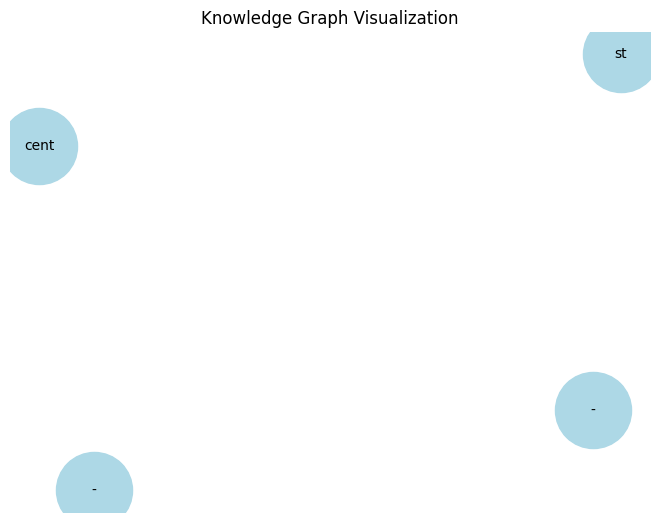

In [180]:
# Preprocess text
sentences = preprocess_text_with_context(input_text, window_size=3)

# Extract entities
entities = modernbert_entity_extraction(sentences)
print("Extracted Entities (Sample):", entities[:5])

# Extract relationships
relationships = modernbert_relationship_extraction(entities, confidence_threshold=0.3)
print("Extracted Relationships (Sample):", relationships[:5])

# Create and visualize graph
create_and_visualize_graph(entities, relationships)
